In [1]:
import numpy as np
import pandas as pd
from math import sqrt

from matplotlib import pyplot
from pandas import read_csv

from pandas import DataFrame
from pandas import concat

import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
!pip install hydroeval


from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pywt
np.random.seed(2020)
from keras import regularizers, optimizers
from keras.models import Sequential, load_model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, LSTM, Bidirectional, BatchNormalization
from keras.layers.core import Dense, Activation
from keras.regularizers import l1_l2, l2
from numpy import array
import warnings

import matplotlib.pyplot as plt
from keras import optimizers

from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import plotly.graph_objs as go

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
df = pd.read_csv('final.csv')
df.head()

,Date,basantpur_rainfall,Andhiyarkhore,Bamnidhi,Simga,Ghatora,Rajim,Rampur,Basantpur
0,01-07-2001,21.944357,5.400,1350.000,35.00,150.000,160.000,108.000,2250.000
1,02-07-2001,3.318059,4.078,496.334,97.25,78.000,150.366,119.859,1353.260
2,03-07-2001,2.335704,3.071,163.761,105.40,35.327,62.633,68.933,1145.230
3,04-07-2001,7.705987,2.343,156.041,67.31,21.230,36.257,48.694,676.221
4,05-07-2001,31.771525,2.321,148.249,48.46,22.491,29.935,23.432,646.760


In [ ]:
cols=list(df)[1:9]
data=df[cols].astype(float)

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data= scaler.fit_transform(data)

In [ ]:
#converts col into different array
R,Qa,Qbi,Qs,Qg,Qr,Qrm,Qb =scaled_data.T

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  #n_vars = 1 if type(data) is list else data.shape[1]
  df = DataFrame(data)
  cols, names = list(), list()
# input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var(t-%d)' % (i))] #for j in range(n_vars)]
# forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [('var(t)')] #for j in range(n_vars)]
    else:
      names += [('var(t+%d)' % (i))] #for j in range(n_vars)]
# put it all together
  agg = concat(cols, axis=1)
  agg.columns = names
# drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)
  return agg

In [ ]:
#Is = series_to_supervised(I,4,2)
Rs = series_to_supervised(R,3,1)
Qas = series_to_supervised(Qa,3,1)
Qbis= series_to_supervised(Qbi,3,1)
Qss = series_to_supervised(Qs,3,1)
Qgs = series_to_supervised(Qg,3,1)
Qrs = series_to_supervised(Qr,3,1)
Qrms = series_to_supervised(Qrm,3,1)
Qbs = series_to_supervised(Qb,3,2)
#Rs = series_to_supervised(R,1,1)

In [ ]:
dfs=[Rs,Qas,Qbis,Qss,Qgs,Qrs,Qrms,Qbs]
Input=pd.concat(dfs,axis=1,keys=range(1,len(dfs)+1))
Input.columns = Input.columns.map('{0[1]}{0[0]}'.format)
Input = Input.iloc[3-0:] #change iloc only if u cange lag days
Input = Input.drop(Input.index[-1:])

In [ ]:
Input

,var(t-3)1,var(t-2)1,var(t-1)1,var(t)1,var(t-3)2,var(t-2)2,var(t-1)2,var(t)2,var(t-3)3,var(t-2)3,...,var(t)6,var(t-3)7,var(t-2)7,var(t-1)7,var(t)7,var(t-3)8,var(t-2)8,var(t-1)8,var(t)8,var(t+1)8
6,0.081014,0.334020,0.308209,0.182478,0.003978,0.003941,0.006606,0.020403,0.018960,0.017951,...,0.124113,0.004401,0.002095,0.002460,0.007934,0.020320,0.019429,0.021313,0.031854,0.039174
7,0.334020,0.308209,0.182478,0.241542,0.003941,0.006606,0.020403,0.011954,0.017951,0.021439,...,0.100364,0.002095,0.002460,0.007934,0.031897,0.019429,0.021313,0.031854,0.039174,0.129853
8,0.308209,0.182478,0.241542,0.409743,0.006606,0.020403,0.011954,0.048305,0.021439,0.052034,...,0.844190,0.002460,0.007934,0.031897,0.126150,0.021313,0.031854,0.039174,0.129853,0.473977
9,0.182478,0.241542,0.409743,0.187636,0.020403,0.011954,0.048305,0.069608,0.052034,0.031128,...,0.414098,0.007934,0.031897,0.126150,0.067826,0.031854,0.039174,0.129853,0.473977,0.302142
10,0.241542,0.409743,0.187636,0.253682,0.011954,0.048305,0.069608,0.039898,0.031128,0.032914,...,0.141782,0.031897,0.126150,0.067826,0.025491,0.039174,0.129853,0.473977,0.302142,0.144966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1006,0.026240,0.048115,0.145416,0.049192,0.053647,0.026902,0.021112,0.018255,0.031069,0.036486,...,0.017562,0.024851,0.015539,0.020225,0.013163,0.107042,0.022709,0.070436,0.060635,0.055443
1007,0.048115,0.145416,0.049192,0.007834,0.026902,0.021112,0.018255,0.018253,0.036486,0.052095,...,0.017530,0.015539,0.020225,0.013163,0.013151,0.022709,0.070436,0.060635,0.055443,0.048120
1008,0.145416,0.049192,0.007834,0.000533,0.021112,0.018255,0.018253,0.014383,0.052095,0.050553,...,0.019187,0.020225,0.013163,0.013151,0.012462,0.070436,0.060635,0.055443,0.048120,0.028554
1009,0.049192,0.007834,0.000533,0.000100,0.018255,0.018253,0.014383,0.013407,0.050553,0.043512,...,0.017202,0.013163,0.013151,0.012462,0.008213,0.060635,0.055443,0.048120,0.028554,0.023694


In [ ]:
y=Input[Input.columns[Input.columns.isin(['var(t+1)8'])]]

In [ ]:
y

,var(t+1)8
6,0.039174
7,0.129853
8,0.473977
9,0.302142
10,0.144966
...,...
1006,0.055443
1007,0.048120
1008,0.028554
1009,0.023694


In [ ]:
x=Input.drop(['var(t+1)8'],axis=1)

In [ ]:
x

,var(t-3)1,var(t-2)1,var(t-1)1,var(t)1,var(t-3)2,var(t-2)2,var(t-1)2,var(t)2,var(t-3)3,var(t-2)3,...,var(t-1)6,var(t)6,var(t-3)7,var(t-2)7,var(t-1)7,var(t)7,var(t-3)8,var(t-2)8,var(t-1)8,var(t)8
6,0.081014,0.334020,0.308209,0.182478,0.003978,0.003941,0.006606,0.020403,0.018960,0.017951,...,0.011465,0.124113,0.004401,0.002095,0.002460,0.007934,0.020320,0.019429,0.021313,0.031854
7,0.334020,0.308209,0.182478,0.241542,0.003941,0.006606,0.020403,0.011954,0.017951,0.021439,...,0.124113,0.100364,0.002095,0.002460,0.007934,0.031897,0.019429,0.021313,0.031854,0.039174
8,0.308209,0.182478,0.241542,0.409743,0.006606,0.020403,0.011954,0.048305,0.021439,0.052034,...,0.100364,0.844190,0.002460,0.007934,0.031897,0.126150,0.021313,0.031854,0.039174,0.129853
9,0.182478,0.241542,0.409743,0.187636,0.020403,0.011954,0.048305,0.069608,0.052034,0.031128,...,0.844190,0.414098,0.007934,0.031897,0.126150,0.067826,0.031854,0.039174,0.129853,0.473977
10,0.241542,0.409743,0.187636,0.253682,0.011954,0.048305,0.069608,0.039898,0.031128,0.032914,...,0.414098,0.141782,0.031897,0.126150,0.067826,0.025491,0.039174,0.129853,0.473977,0.302142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1006,0.026240,0.048115,0.145416,0.049192,0.053647,0.026902,0.021112,0.018255,0.031069,0.036486,...,0.027269,0.017562,0.024851,0.015539,0.020225,0.013163,0.107042,0.022709,0.070436,0.060635
1007,0.048115,0.145416,0.049192,0.007834,0.026902,0.021112,0.018255,0.018253,0.036486,0.052095,...,0.017562,0.017530,0.015539,0.020225,0.013163,0.013151,0.022709,0.070436,0.060635,0.055443
1008,0.145416,0.049192,0.007834,0.000533,0.021112,0.018255,0.018253,0.014383,0.052095,0.050553,...,0.017530,0.019187,0.020225,0.013163,0.013151,0.012462,0.070436,0.060635,0.055443,0.048120
1009,0.049192,0.007834,0.000533,0.000100,0.018255,0.018253,0.014383,0.013407,0.050553,0.043512,...,0.019187,0.017202,0.013163,0.013151,0.012462,0.008213,0.060635,0.055443,0.048120,0.028554


In [ ]:
x_train=x[:456]
x_val=x[456:639]
x_test=x[639:]
y_train=y[:456]
y_val=y[456:639]
y_test=y[639:]

In [ ]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape,x_val.shape,y_val.shape

((456, 32), (366, 32), (456, 1), (366, 1), (183, 32), (183, 1))

In [ ]:
#converting dataframe to array to reshape in next step
x_train=x_train.values
y_train=y_train.values
x_test=x_test.values
y_test=y_test.values
x_val=x_val.values
y_val=y_val.values

In [ ]:
#reshape into 3-D cz model cannot perform in 2-D
x_train = x_train.reshape((x_train.shape[0],1,x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0],1,x_val.shape[1]))
x_test = x_test.reshape((x_test.shape[0],1,x_test.shape[1]))

In [ ]:
x_train.shape,x_test.shape,x_val.shape

((456, 1, 32), (366, 1, 32), (183, 1, 32))

In [ ]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(x_train.shape[1],x_train.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer='adam')
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                16600     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 16,651
Trainable params: 16,651
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstm_history = model_lstm.fit(x_train, y_train, epochs=1000,batch_size=128, verbose=1,validation_data=(x_val, y_val))

Epoch 1/1000
4/4 [==============================] - 2s 90ms/step - loss: 0.0146 - val_loss: 0.0114
Epoch 2/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.0110 - val_loss: 0.0086
Epoch 3/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.0081 - val_loss: 0.0066
Epoch 4/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.0064 - val_loss: 0.0052
Epoch 5/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.0054 - val_loss: 0.0045
Epoch 6/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.0051 - val_loss: 0.0042
Epoch 7/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.0050 - val_loss: 0.0040
Epoch 8/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.0048 - val_loss: 0.0038
Epoch 9/1000
4/4 [==============================] - 0s 18ms/step - loss: 0.0045 - val_loss: 0.0037
Epoch 10/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.0041 - val_loss: 0.0037
Epoch 11/

4/4 [==============================] - 0s 22ms/step - loss: 3.7364e-04 - val_loss: 0.0015
Epoch 82/1000
4/4 [==============================] - 0s 18ms/step - loss: 3.6948e-04 - val_loss: 0.0015
Epoch 83/1000
4/4 [==============================] - 0s 18ms/step - loss: 3.6690e-04 - val_loss: 0.0015
Epoch 84/1000
4/4 [==============================] - 0s 17ms/step - loss: 3.6478e-04 - val_loss: 0.0015
Epoch 85/1000
4/4 [==============================] - 0s 18ms/step - loss: 3.6139e-04 - val_loss: 0.0015
Epoch 86/1000
4/4 [==============================] - 0s 18ms/step - loss: 3.6099e-04 - val_loss: 0.0015
Epoch 87/1000
4/4 [==============================] - 0s 19ms/step - loss: 3.5294e-04 - val_loss: 0.0015
Epoch 88/1000
4/4 [==============================] - 0s 21ms/step - loss: 3.5541e-04 - val_loss: 0.0015
Epoch 89/1000
4/4 [==============================] - 0s 19ms/step - loss: 3.5126e-04 - val_loss: 0.0015
Epoch 90/1000
4/4 [==============================] - 0s 18ms/step - loss: 3.46

4/4 [==============================] - 0s 23ms/step - loss: 2.1762e-04 - val_loss: 0.0015
Epoch 160/1000
4/4 [==============================] - 0s 22ms/step - loss: 2.1532e-04 - val_loss: 0.0015
Epoch 161/1000
4/4 [==============================] - 0s 21ms/step - loss: 2.1370e-04 - val_loss: 0.0015
Epoch 162/1000
4/4 [==============================] - 0s 19ms/step - loss: 2.1128e-04 - val_loss: 0.0015
Epoch 163/1000
4/4 [==============================] - 0s 21ms/step - loss: 2.1109e-04 - val_loss: 0.0015
Epoch 164/1000
4/4 [==============================] - 0s 22ms/step - loss: 2.1011e-04 - val_loss: 0.0015
Epoch 165/1000
4/4 [==============================] - 0s 19ms/step - loss: 2.0849e-04 - val_loss: 0.0015
Epoch 166/1000
4/4 [==============================] - 0s 17ms/step - loss: 2.0694e-04 - val_loss: 0.0015
Epoch 167/1000
4/4 [==============================] - 0s 17ms/step - loss: 2.0519e-04 - val_loss: 0.0016
Epoch 168/1000
4/4 [==============================] - 0s 17ms/step - l

4/4 [==============================] - 0s 17ms/step - loss: 1.4353e-04 - val_loss: 0.0016
Epoch 238/1000
4/4 [==============================] - 0s 18ms/step - loss: 1.4212e-04 - val_loss: 0.0016
Epoch 239/1000
4/4 [==============================] - 0s 17ms/step - loss: 1.4436e-04 - val_loss: 0.0016
Epoch 240/1000
4/4 [==============================] - 0s 17ms/step - loss: 1.4167e-04 - val_loss: 0.0016
Epoch 241/1000
4/4 [==============================] - 0s 18ms/step - loss: 1.3882e-04 - val_loss: 0.0016
Epoch 242/1000
4/4 [==============================] - 0s 18ms/step - loss: 1.3864e-04 - val_loss: 0.0016
Epoch 243/1000
4/4 [==============================] - 0s 17ms/step - loss: 1.3896e-04 - val_loss: 0.0016
Epoch 244/1000
4/4 [==============================] - 0s 17ms/step - loss: 1.3653e-04 - val_loss: 0.0016
Epoch 245/1000
4/4 [==============================] - 0s 17ms/step - loss: 1.3510e-04 - val_loss: 0.0016
Epoch 246/1000
4/4 [==============================] - 0s 18ms/step - l

4/4 [==============================] - 0s 17ms/step - loss: 1.0180e-04 - val_loss: 0.0017
Epoch 316/1000
4/4 [==============================] - 0s 17ms/step - loss: 1.0326e-04 - val_loss: 0.0016
Epoch 317/1000
4/4 [==============================] - 0s 17ms/step - loss: 1.0077e-04 - val_loss: 0.0016
Epoch 318/1000
4/4 [==============================] - 0s 18ms/step - loss: 1.0165e-04 - val_loss: 0.0016
Epoch 319/1000
4/4 [==============================] - 0s 17ms/step - loss: 1.0123e-04 - val_loss: 0.0016
Epoch 320/1000
4/4 [==============================] - 0s 17ms/step - loss: 1.0051e-04 - val_loss: 0.0016
Epoch 321/1000
4/4 [==============================] - 0s 18ms/step - loss: 1.0064e-04 - val_loss: 0.0017
Epoch 322/1000
4/4 [==============================] - 0s 18ms/step - loss: 9.9447e-05 - val_loss: 0.0016
Epoch 323/1000
4/4 [==============================] - 0s 18ms/step - loss: 9.9286e-05 - val_loss: 0.0016
Epoch 324/1000
4/4 [==============================] - 0s 17ms/step - l

4/4 [==============================] - 0s 17ms/step - loss: 8.1419e-05 - val_loss: 0.0017
Epoch 394/1000
4/4 [==============================] - 0s 18ms/step - loss: 8.0223e-05 - val_loss: 0.0017
Epoch 395/1000
4/4 [==============================] - 0s 17ms/step - loss: 7.9811e-05 - val_loss: 0.0017
Epoch 396/1000
4/4 [==============================] - 0s 17ms/step - loss: 7.9896e-05 - val_loss: 0.0017
Epoch 397/1000
4/4 [==============================] - 0s 17ms/step - loss: 7.8553e-05 - val_loss: 0.0017
Epoch 398/1000
4/4 [==============================] - 0s 17ms/step - loss: 7.8921e-05 - val_loss: 0.0017
Epoch 399/1000
4/4 [==============================] - 0s 19ms/step - loss: 7.9800e-05 - val_loss: 0.0017
Epoch 400/1000
4/4 [==============================] - 0s 17ms/step - loss: 7.9396e-05 - val_loss: 0.0017
Epoch 401/1000
4/4 [==============================] - 0s 17ms/step - loss: 7.9557e-05 - val_loss: 0.0017
Epoch 402/1000
4/4 [==============================] - 0s 20ms/step - l

4/4 [==============================] - 0s 18ms/step - loss: 6.5838e-05 - val_loss: 0.0017
Epoch 472/1000
4/4 [==============================] - 0s 18ms/step - loss: 6.5648e-05 - val_loss: 0.0017
Epoch 473/1000
4/4 [==============================] - 0s 18ms/step - loss: 6.5787e-05 - val_loss: 0.0017
Epoch 474/1000
4/4 [==============================] - 0s 17ms/step - loss: 6.6604e-05 - val_loss: 0.0017
Epoch 475/1000
4/4 [==============================] - 0s 18ms/step - loss: 6.6490e-05 - val_loss: 0.0017
Epoch 476/1000
4/4 [==============================] - 0s 18ms/step - loss: 6.6083e-05 - val_loss: 0.0017
Epoch 477/1000
4/4 [==============================] - 0s 17ms/step - loss: 6.5150e-05 - val_loss: 0.0017
Epoch 478/1000
4/4 [==============================] - 0s 17ms/step - loss: 6.5181e-05 - val_loss: 0.0017
Epoch 479/1000
4/4 [==============================] - 0s 17ms/step - loss: 6.4260e-05 - val_loss: 0.0017
Epoch 480/1000
4/4 [==============================] - 0s 18ms/step - l

4/4 [==============================] - 0s 18ms/step - loss: 5.5450e-05 - val_loss: 0.0017
Epoch 550/1000
4/4 [==============================] - 0s 17ms/step - loss: 5.5515e-05 - val_loss: 0.0017
Epoch 551/1000
4/4 [==============================] - 0s 21ms/step - loss: 5.4946e-05 - val_loss: 0.0017
Epoch 552/1000
4/4 [==============================] - 0s 18ms/step - loss: 5.5698e-05 - val_loss: 0.0017
Epoch 553/1000
4/4 [==============================] - 0s 17ms/step - loss: 5.5053e-05 - val_loss: 0.0017
Epoch 554/1000
4/4 [==============================] - 0s 19ms/step - loss: 5.4871e-05 - val_loss: 0.0017
Epoch 555/1000
4/4 [==============================] - 0s 19ms/step - loss: 5.4542e-05 - val_loss: 0.0017
Epoch 556/1000
4/4 [==============================] - 0s 18ms/step - loss: 5.4642e-05 - val_loss: 0.0017
Epoch 557/1000
4/4 [==============================] - 0s 18ms/step - loss: 5.6011e-05 - val_loss: 0.0017
Epoch 558/1000
4/4 [==============================] - 0s 18ms/step - l

4/4 [==============================] - 0s 21ms/step - loss: 4.9242e-05 - val_loss: 0.0018
Epoch 628/1000
4/4 [==============================] - 0s 18ms/step - loss: 5.0127e-05 - val_loss: 0.0018
Epoch 629/1000
4/4 [==============================] - 0s 19ms/step - loss: 5.0432e-05 - val_loss: 0.0018
Epoch 630/1000
4/4 [==============================] - 0s 24ms/step - loss: 4.9956e-05 - val_loss: 0.0018
Epoch 631/1000
4/4 [==============================] - 0s 21ms/step - loss: 4.9832e-05 - val_loss: 0.0018
Epoch 632/1000
4/4 [==============================] - 0s 21ms/step - loss: 5.0008e-05 - val_loss: 0.0018
Epoch 633/1000
4/4 [==============================] - 0s 19ms/step - loss: 5.0340e-05 - val_loss: 0.0018
Epoch 634/1000
4/4 [==============================] - 0s 25ms/step - loss: 4.8703e-05 - val_loss: 0.0018
Epoch 635/1000
4/4 [==============================] - 0s 22ms/step - loss: 4.8333e-05 - val_loss: 0.0018
Epoch 636/1000
4/4 [==============================] - 0s 21ms/step - l

4/4 [==============================] - 0s 18ms/step - loss: 4.2172e-05 - val_loss: 0.0018
Epoch 706/1000
4/4 [==============================] - 0s 18ms/step - loss: 4.2337e-05 - val_loss: 0.0018
Epoch 707/1000
4/4 [==============================] - 0s 17ms/step - loss: 4.2617e-05 - val_loss: 0.0018
Epoch 708/1000
4/4 [==============================] - 0s 17ms/step - loss: 4.1974e-05 - val_loss: 0.0018
Epoch 709/1000
4/4 [==============================] - 0s 16ms/step - loss: 4.2680e-05 - val_loss: 0.0018
Epoch 710/1000
4/4 [==============================] - 0s 17ms/step - loss: 4.2548e-05 - val_loss: 0.0018
Epoch 711/1000
4/4 [==============================] - 0s 17ms/step - loss: 4.1845e-05 - val_loss: 0.0018
Epoch 712/1000
4/4 [==============================] - 0s 17ms/step - loss: 4.1833e-05 - val_loss: 0.0018
Epoch 713/1000
4/4 [==============================] - 0s 17ms/step - loss: 4.1409e-05 - val_loss: 0.0018
Epoch 714/1000
4/4 [==============================] - 0s 17ms/step - l

4/4 [==============================] - 0s 17ms/step - loss: 3.8978e-05 - val_loss: 0.0018
Epoch 784/1000
4/4 [==============================] - 0s 19ms/step - loss: 3.9361e-05 - val_loss: 0.0019
Epoch 785/1000
4/4 [==============================] - 0s 22ms/step - loss: 3.8027e-05 - val_loss: 0.0019
Epoch 786/1000
4/4 [==============================] - 0s 20ms/step - loss: 3.7126e-05 - val_loss: 0.0018
Epoch 787/1000
4/4 [==============================] - 0s 17ms/step - loss: 3.8242e-05 - val_loss: 0.0018
Epoch 788/1000
4/4 [==============================] - 0s 20ms/step - loss: 3.7238e-05 - val_loss: 0.0019
Epoch 789/1000
4/4 [==============================] - 0s 17ms/step - loss: 3.7071e-05 - val_loss: 0.0018
Epoch 790/1000
4/4 [==============================] - 0s 17ms/step - loss: 3.7460e-05 - val_loss: 0.0019
Epoch 791/1000
4/4 [==============================] - 0s 17ms/step - loss: 3.7162e-05 - val_loss: 0.0019
Epoch 792/1000
4/4 [==============================] - 0s 17ms/step - l

4/4 [==============================] - 0s 17ms/step - loss: 3.5502e-05 - val_loss: 0.0019
Epoch 862/1000
4/4 [==============================] - 0s 17ms/step - loss: 3.4491e-05 - val_loss: 0.0019
Epoch 863/1000
4/4 [==============================] - 0s 17ms/step - loss: 3.5292e-05 - val_loss: 0.0019
Epoch 864/1000
4/4 [==============================] - 0s 17ms/step - loss: 3.4450e-05 - val_loss: 0.0019
Epoch 865/1000
4/4 [==============================] - 0s 18ms/step - loss: 3.4927e-05 - val_loss: 0.0019
Epoch 866/1000
4/4 [==============================] - 0s 17ms/step - loss: 3.3867e-05 - val_loss: 0.0019
Epoch 867/1000
4/4 [==============================] - 0s 17ms/step - loss: 3.3955e-05 - val_loss: 0.0019
Epoch 868/1000
4/4 [==============================] - 0s 17ms/step - loss: 3.4683e-05 - val_loss: 0.0019
Epoch 869/1000
4/4 [==============================] - 0s 18ms/step - loss: 3.3549e-05 - val_loss: 0.0019
Epoch 870/1000
4/4 [==============================] - 0s 17ms/step - l

4/4 [==============================] - 0s 18ms/step - loss: 3.1306e-05 - val_loss: 0.0019
Epoch 940/1000
4/4 [==============================] - 0s 18ms/step - loss: 3.2359e-05 - val_loss: 0.0020
Epoch 941/1000
4/4 [==============================] - 0s 20ms/step - loss: 3.2782e-05 - val_loss: 0.0019
Epoch 942/1000
4/4 [==============================] - 0s 19ms/step - loss: 3.2529e-05 - val_loss: 0.0020
Epoch 943/1000
4/4 [==============================] - 0s 20ms/step - loss: 3.3637e-05 - val_loss: 0.0020
Epoch 944/1000
4/4 [==============================] - 0s 18ms/step - loss: 3.7676e-05 - val_loss: 0.0019
Epoch 945/1000
4/4 [==============================] - 0s 18ms/step - loss: 3.4402e-05 - val_loss: 0.0019
Epoch 946/1000
4/4 [==============================] - 0s 18ms/step - loss: 3.4933e-05 - val_loss: 0.0020
Epoch 947/1000
4/4 [==============================] - 0s 17ms/step - loss: 3.6868e-05 - val_loss: 0.0020
Epoch 948/1000
4/4 [==============================] - 0s 18ms/step - l

In [ ]:
hist_df = pd.DataFrame( lstm_history.history )
hist_df

,loss,val_loss
0,0.014624,0.011449
1,0.010978,0.008627
2,0.008082,0.006569
3,0.006445,0.005204
4,0.005432,0.004495
...,...,...
995,0.000029,0.001989
996,0.000029,0.001998
997,0.000029,0.001999
998,0.000030,0.002006


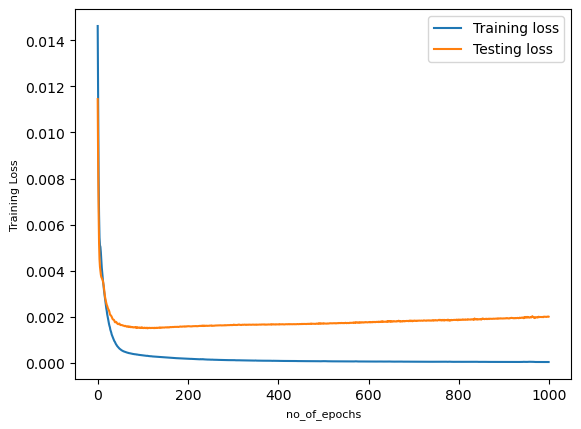

In [ ]:
plt.plot(lstm_history.history['loss'],label='Training loss' )
plt.plot(lstm_history.history['val_loss'], label='Testing loss')
plt.xlabel('no_of_epochs', fontsize=8 )
plt.ylabel('Training Loss', fontsize=8 )
plt.legend()

In [ ]:
train_yp = model_lstm.predict(x_train)
val_yp = model_lstm.predict(x_val)
test_yp = model_lstm.predict(x_test)

12/12 [==============================] - 0s 2ms/step


In [ ]:
x_train = x_train.reshape((x_train.shape[0],x_train.shape[2]))
x_val= x_val.reshape((x_val.shape[0],x_val.shape[2]))
x_test= x_test.reshape((x_test.shape[0],x_test.shape[2]))

In [ ]:
x_train.shape, x_val.shape,x_test.shape

((456, 32), (183, 32), (366, 32))

In [ ]:
#inverse_transform
#1)x_train
inv_x_train=pd.concat([pd.DataFrame(train_yp), pd.DataFrame(x_train[:, :7])], axis=1)
rev_trans=scaler.inverse_transform(inv_x_train) 
y_train_prediction=rev_trans[:,0]

#y_train
inv_y_train=pd.concat([pd.DataFrame(y_train), pd.DataFrame(x_train[:, :7])], axis=1)
rev_trans=scaler.inverse_transform(inv_y_train) 
y_train_Observed=rev_trans[:,0]

#x_val
inv_x_val=pd.concat([pd.DataFrame(val_yp), pd.DataFrame(x_train[:, :7])], axis=1)
rev_trans=scaler.inverse_transform(inv_x_val) 
y_val_prediction=rev_trans[:,0]

#y_val
inv_y_val=pd.concat([pd.DataFrame(y_val), pd.DataFrame(x_train[:, :7])], axis=1)
rev_trans=scaler.inverse_transform(inv_y_val) 
y_val_Observed=rev_trans[:,0]

#x_test
inv_x_test=pd.concat([pd.DataFrame(test_yp), pd.DataFrame(x_train[:, :7])], axis=1)
rev_trans=scaler.inverse_transform(inv_x_test) 
y_test_prediction=rev_trans[:,0]

#y_test
inv_y_test=pd.concat([pd.DataFrame(y_test), pd.DataFrame(x_train[:, :7])], axis=1)
rev_trans=scaler.inverse_transform(inv_y_test) 
y_test_Observed=rev_trans[:,0]

In [ ]:
y_test_prediction.shape, y_test_Observed.shape

((456,), (456,))

<AxesSubplot:>

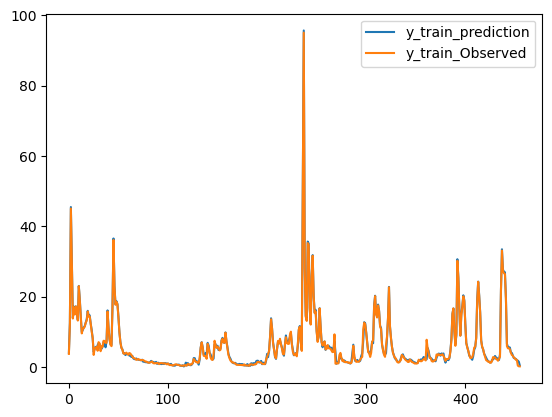

In [ ]:
y_train_pre=np.array(y_train_prediction)
y_train_rev=np.array(y_train_Observed)
l=np.array([y_train_prediction,y_train_Observed])
dataset=pd.DataFrame(l)
dataset=dataset.transpose()
dataset.columns = ['y_train_prediction', 'y_train_Observed']
dataset[['y_train_prediction','y_train_Observed']].plot()

In [ ]:
from hydroeval import evaluator, nse

NSE_train = evaluator(nse,y_train_prediction , y_train_Observed )
print(NSE_train)

[0.99597824]


<AxesSubplot:>

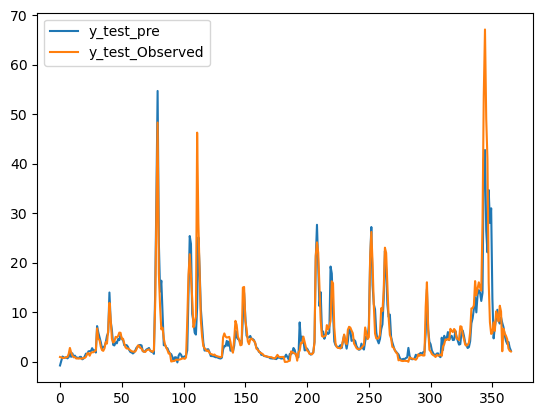

In [ ]:
#test
y_test_pre=np.array(y_test_prediction)
y_test_Observed=np.array(y_test_Observed)
l=np.array([y_test_prediction,y_test_Observed])
dataset=pd.DataFrame(l)
dataset_test=dataset.transpose()
dataset_test.columns = ['y_test_pre', 'y_test_Observed']
dataset_test[['y_test_pre','y_test_Observed']].plot()

In [ ]:
from hydroeval import evaluator, nse

NSE_test = evaluator(nse,y_test_pre , y_test_Observed )
#NSE_test = evaluator( nse,predicted_test_saved ,observed_y__test_saved  )

print(NSE_test)

[0.75303327]


<AxesSubplot:>

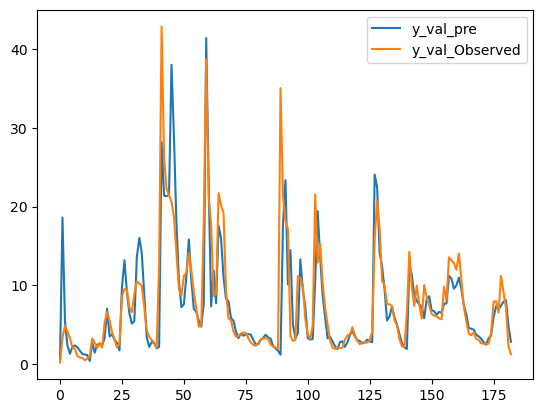

In [ ]:
y_val_pre=np.array(y_val_prediction)
y_val_Observed=np.array(y_val_Observed)
l=np.array([y_val_prediction,y_val_Observed])
dataset_val=pd.DataFrame(l)
dataset_val=dataset_val.transpose()
dataset_val.columns = ['y_val_pre', 'y_val_Observed']
dataset_val[['y_val_pre','y_val_Observed']].plot()

In [ ]:
NSE_val = evaluator(nse,y_val_pre , y_val_Observed )
print(NSE_val)

[0.61045665]


C:\Users\RAJAN\AppData\Local\Temp\ipykernel_10496\47633976.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_lim, y_lim, 'k-', color = 'black', label = '1:1 line')


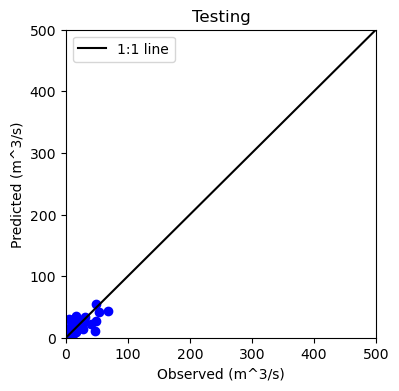

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4), dpi=100)
plt.scatter(y_test_Observed,y_test_pre, color='b')
y_lim = plt.ylim([0, 500])
x_lim = plt.ylim([0, 500])
plt.plot(x_lim, y_lim, 'k-', color = 'black', label = '1:1 line')
plt.ylim(y_lim)
plt.xlim(x_lim)
plt.title('Testing')
plt.xlabel("Observed (m^3/s)")
plt.ylabel("Predicted (m^3/s)")
plt.legend()

In [ ]:
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error
np.random.seed(2020)
from hydroeval import evaluator,nse,kge,kgeprime,rmse,mare,pbias

NSE_train = evaluator(nse,y_train_prediction , y_train_Observed )
NSE_val = evaluator(nse,y_val_pre , y_val_Observed )
NSE_test = evaluator(nse,y_test_pre , y_test_Observed )

RMSE_Training =evaluator(rmse,y_train_prediction , y_train_Observed)
RMSE_val = evaluator(rmse,y_val_pre, y_val_Observed)
RMSE_Testing = evaluator(rmse,y_test_pre , y_test_Observed)


MARE_Training =evaluator(mare,y_train_pre,y_train_Observed)
MARE_val = evaluator(mare,y_val_pre, y_val_Observed)
MARE_Testing = evaluator(mare,y_test_pre , y_test_Observed)
    
    
PBIAS_Training =evaluator(pbias,y_train_pre ,y_train_Observed)
PBIAS_val = evaluator(pbias,y_val_pre, y_val_Observed)
PBIAS_Testing = evaluator(pbias,y_test_pre , y_test_Observed)
    
    
# corr_train ,p_value_train = pearsonr(y_train_pre, y_train_Observed)
# corr_test ,p_value_test = pearsonr(y_test_pre,  y_test_Observed)
    
        
# mae_train = mean_absolute_error(y_train_Observed, y_train_pre) 
# mae_test = mean_absolute_error( y_test_Observed,y_test_pre) 
    
v_error_train = (np.sum(y_train_pre)-np.sum(y_train_Observed))/np.sum(y_train_Observed)
v_error_val  = (np.sum(y_val_pre)-np.sum(y_val_Observed))/np.sum(y_val_Observed) 
v_error_test  = (np.sum(y_test_pre)-np.sum(y_test_Observed))/np.sum(y_test_Observed)   

In [ ]:
results=[NSE_train,NSE_val,NSE_test,RMSE_Training,RMSE_val,RMSE_Testing, MARE_Training,MARE_val,MARE_Testing, PBIAS_Training,PBIAS_val,PBIAS_Testing,v_error_train,v_error_val,v_error_test]
l=np.array([results])
res=pd.DataFrame(l).transpose()
res

C:\Users\RAJAN\AppData\Local\Temp\ipykernel_10496\1293589194.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  l=np.array([results])


,0
0,[0.9959782358051497]
1,[0.6104566481119802]
2,[0.7530332687404044]
3,[0.5222768866372359]
4,[4.2526305923125625]
5,[3.9309738711768185]
6,[0.05045378425341304]
7,[0.2721122458798088]
8,[0.28204978765434846]
9,[-1.5055571683904543]


In [ ]:
#to save as csv file

# dataset.to_csv('/content/gdrive/MyDrive/Results_MTP/LSTM_model/LSTM_model_1_day_train_OP.csv')
# dataset_val.to_csv('/content/gdrive/MyDrive/Results_MTP/LSTM_model/LSTM_model_1_day_val_OP.csv')
# dataset_test.to_csv('/content/gdrive/MyDrive/Results_MTP/LSTM_model/LSTM_model_1_day_test_OP.csv')
# res.to_csv('/content/gdrive/MyDrive/Results_MTP/LSTM_model/LSTM_model_1_day_results.csv')

In [ ]:
res.to_csv(r'D:\iitkgp\saa\lstm1.csv')